In [1]:
import os, time 
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import matplotlib.pyplot as plt
from keras import Sequential,layers, models, Model
from keras.optimizers import Adam
from keras.layers import Dense, Conv2D, Flatten, Reshape, Conv2DTranspose, MaxPooling2D
from keras.layers import LeakyReLU, Dropout, BatchNormalization, Input, Activation, ZeroPadding2D
from keras.utils import plot_model
from keras.models import load_model
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D
from keras.optimizers import RMSprop, SGD

import keras.backend as K

import sys
import warnings
warnings.filterwarnings("ignore")

## Model

In [2]:
class GAN():
    def __init__(self, Ntrain, img_dim, lr, types):
        self.Ntrain = Ntrain
        self.img_rows = img_dim
        self.img_cols = img_dim
        self.channels = 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100
        self.path = '/home/roytsai/sally/dataset/img_align_celeba/img_align_celeba/'
        self.dir_result="/home/roytsai/sally/dataset/result_%s/"%(types)
        self.type_name = types
        
        # Following parameter and optimizer set as recommended in paper
        self.n_critic = 5
        self.clip_value = 0.01
        optimizer = Adam(lr = lr)
        
        # Build the generator
        self.generator = self.build_generator()
        
        # Build and compile the discriminator
        self.discri = self.build_discriminator() 
        self.discri.compile(loss = 'binary_crossentropy',
            optimizer = optimizer,
            metrics=['accuracy'])
        
        # The generator takes noise as input and generated imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)
        
        # For the combined model we will only train the generator
        self.discri.trainable = False
        
        # The discriminator takes generated images as input and determines validity
        valid = self.discri(img)

        # The combined model  (stacked generator and discriminator)
        self.combined = Model(z, valid)
        self.combined.compile(loss = 'binary_crossentropy',
            optimizer = optimizer,
            metrics = ['accuracy'])
        
    def load_data(self):
        nm_imgs       = np.sort(os.listdir(self.path))
        ## name of the jpg files for training set
        nm_imgs_train = nm_imgs[:self.Ntrain]

        X_train = []
        for i, myid in enumerate(nm_imgs_train):
            image = load_img(self.path + myid,
                            target_size = self.img_shape[:2])
            image = img_to_array(image)/255.0
            X_train.append(image)
        X_train = np.array(X_train)
        return(X_train)

    def wasserstein_loss(self, y_true, y_pred):
        return K.mean(y_true * y_pred)
    
    def build_generator(self):

        model = Sequential()
        
        dim = int(self.img_rows/16)
        model.add(Dense(256 * dim * dim, input_dim = self.latent_dim))
        model.add(Reshape((dim, dim, 256)))
        
        model.add(Conv2DTranspose(64, (4,4), strides=(2,2), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        
        model.add(Conv2DTranspose(64, (4,4), strides=(2,2), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        
        model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
    
        model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Conv2D(3, (7,7), activation='tanh', padding='same'))

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)
        
    
    def build_discriminator(self):

        model = Sequential()

        model.add(Conv2D(32, (3,3), activation='relu', padding='same', input_shape=self.img_shape))
        model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
        model.add(MaxPooling2D((2, 2), strides=(2, 2)))
        
        model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
        model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
        model.add(MaxPooling2D((2, 2), strides=(2, 2)))
        
        model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
        model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
        model.add(MaxPooling2D((2, 2), strides=(1, 1)))
        
        model.add(Flatten())
        model.add(Dropout(0.3))
        model.add(Dense(1, activation='sigmoid'))

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)
        
    
    def train(self, epochs, batch_size):

        #load data
        X_train = self.load_data()
        half_batch  = int(batch_size / 2)
        
        # save the result
        history = []

        for epoch in range(epochs):


            # ---------------------
            #  Train Discriminator
            # ---------------------
            
            # Select a random half batch of images
            idx = np.random.randint(0, X_train.shape[0], half_batch)
            imgs = X_train[idx]
            
            # Sample noise as generator input
            noise = np.random.normal(0, 1, (half_batch, self.latent_dim))

            # Generate a half batch of new images
            gen_imgs = self.generator.predict(noise)

            
            # Train the discriminator q: better to mix them together?
            d_loss_real = self.discri.train_on_batch(imgs, np.ones((half_batch, 1)))
            d_loss_fake = self.discri.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)


            # ---------------------
            #  Train Generator
            # ---------------------
            
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # The generator wants the discriminator to label the generated samples
            # as valid (ones)
            valid_y = (np.array([1] * batch_size)).reshape(batch_size,1)
            
            # Train the generator
            g_loss = self.combined.train_on_batch(noise, valid_y)

            history.append({"D":d_loss[0],"G":g_loss[0]})
            
            
            # save generated image samples
            if epoch % 500 == 0:
                self.plot_generated_images(epoch,save = "yes")
                
        return(history)
    
    def plot_generated_images(self, epoch, save = None):
        nsample = 4
        noise = np.random.normal(0, 1, (nsample, self.latent_dim))
        imgs = self.generator.predict(noise)
        fig = plt.figure(figsize=(40,10))
        for i, img in enumerate(imgs):
            ax = fig.add_subplot(1,nsample,i+1)
            ax.imshow(img)
        fig.suptitle("Generated images Epoch {}".format(epoch), fontsize=30)

        if save is not None:
            try:
                os.mkdir(self.dir_result)
            except:
                pass
            
            plt.savefig(self.dir_result + "image_%5.0f.png"%(epoch),
                        bbox_inches='tight', pad_inches=0)
            plt.close()
        else:
            plt.show()
    
    # plot loss
    def plot_result(self, history):
        hist = pd.DataFrame(history)
        plt.figure(figsize=(20,5))
        for colnm in hist.columns:
            plt.plot(hist[colnm],label=colnm)
        plt.legend()
        plt.ylabel("loss")
        plt.xlabel("epochs")
        plt.savefig("/home/roytsai/sally/dataset/loss_plot/"+ self.type_name)
        plt.show()
        plt.close()
        
    # transfrom to gif
    def makegif(self):
        import imageio
        dir_images = self.dir_result
        filenames = np.sort(os.listdir(dir_images))
        filenames = [ fnm for fnm in filenames if ".png" in fnm]
        
        with imageio.get_writer(dir_images + 'image.gif', mode='I') as writer:
            for filename in filenames:
                image = imageio.imread(dir_images + filename)
                writer.append_data(image)
                os.remove(dir_images + filename)


## Experiment

In [3]:
# all_time = []
# for lrt in [0.0003,0.0001,0.00007]:
#     for dims in [32,64,128]:
#         gan = GAN(Ntrain = 10000, img_dim = dims, lr = lrt, types = "test%s_%s_4"%(dims,str(lrt)[2:]))
#         start_time = time.time()
#         history = gan.train(epochs = 15000, batch_size = 64)
#         end_time = time.time()
#         all_time.append([lrt,dims,(end_time - start_time)/60])
#         gan.plot_result(history)
#         gan.makegif()

# times = pd.DataFrame(all_time,columns = ['lr','dim','time'])

# times.to_csv("total_run_time.csv")

# Plot

In [4]:
from IPython.display import Image
os.chdir("/Users/sally/Desktop/GMBA_result/")

## Compare the time on different learning rate and dimention

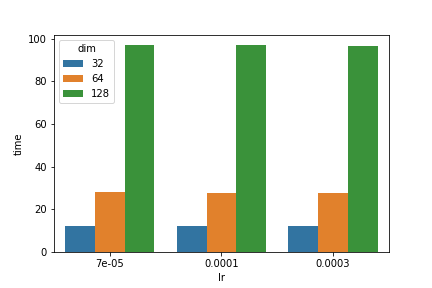

In [5]:
Image(filename="time.png",width=400,height=400)

## Compare different learning rate & dimention

### dim = 32

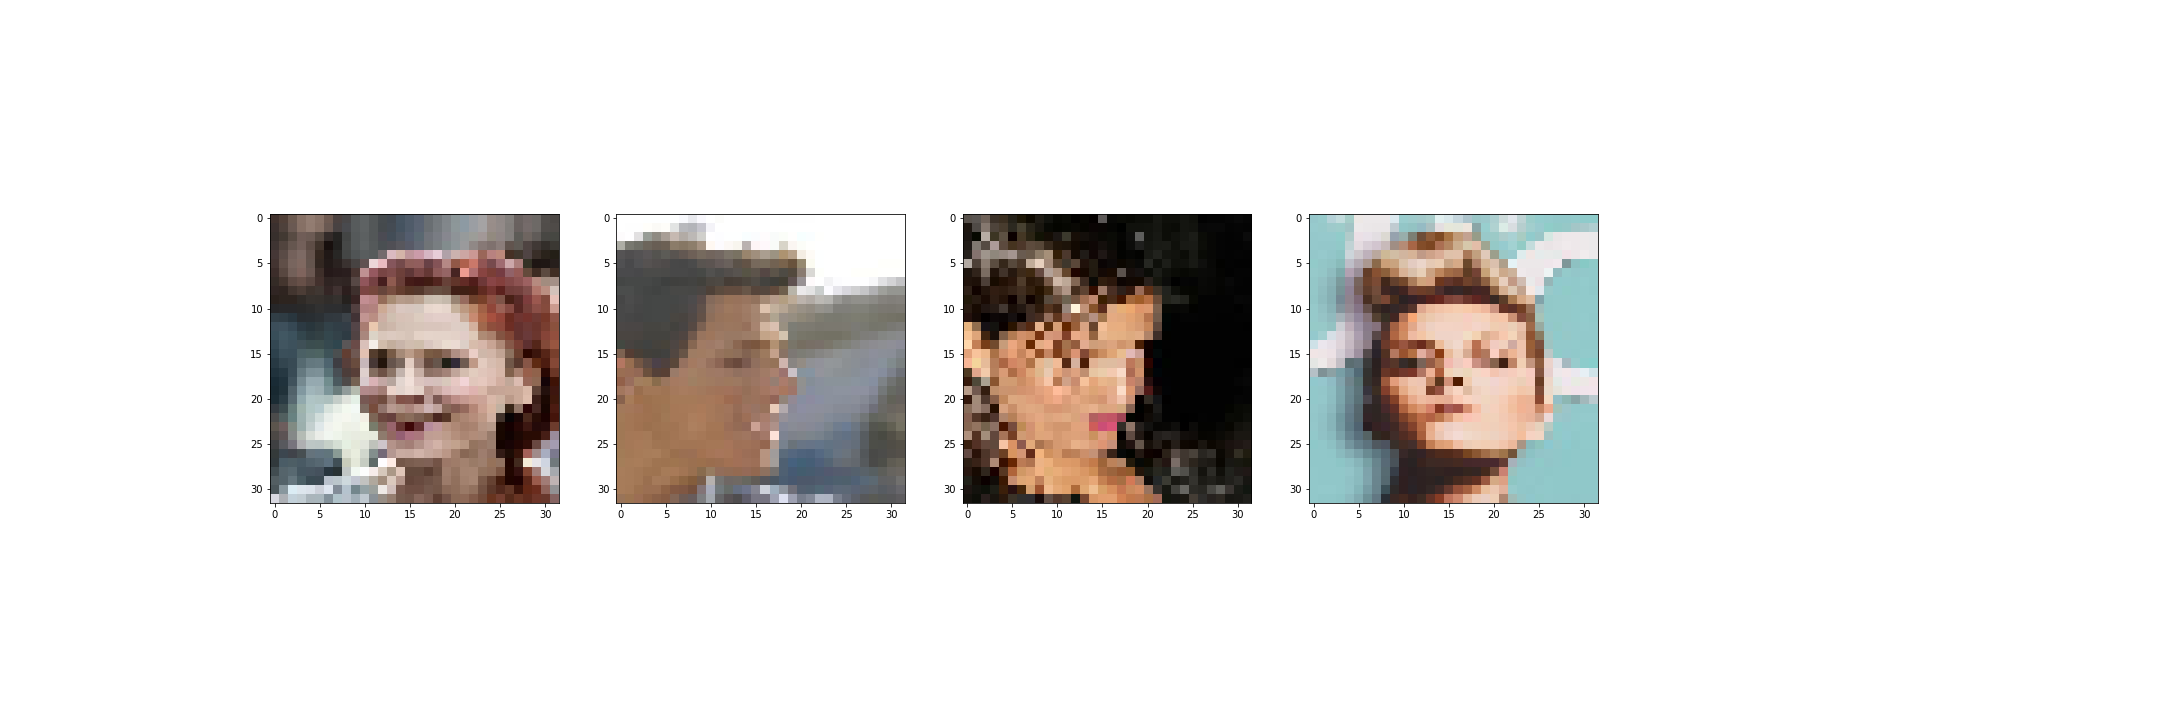

In [6]:
# original photo
Image(filename="./original_photo/original_dim32.png",width=1000,height=1000)

### lr = 0.0003 

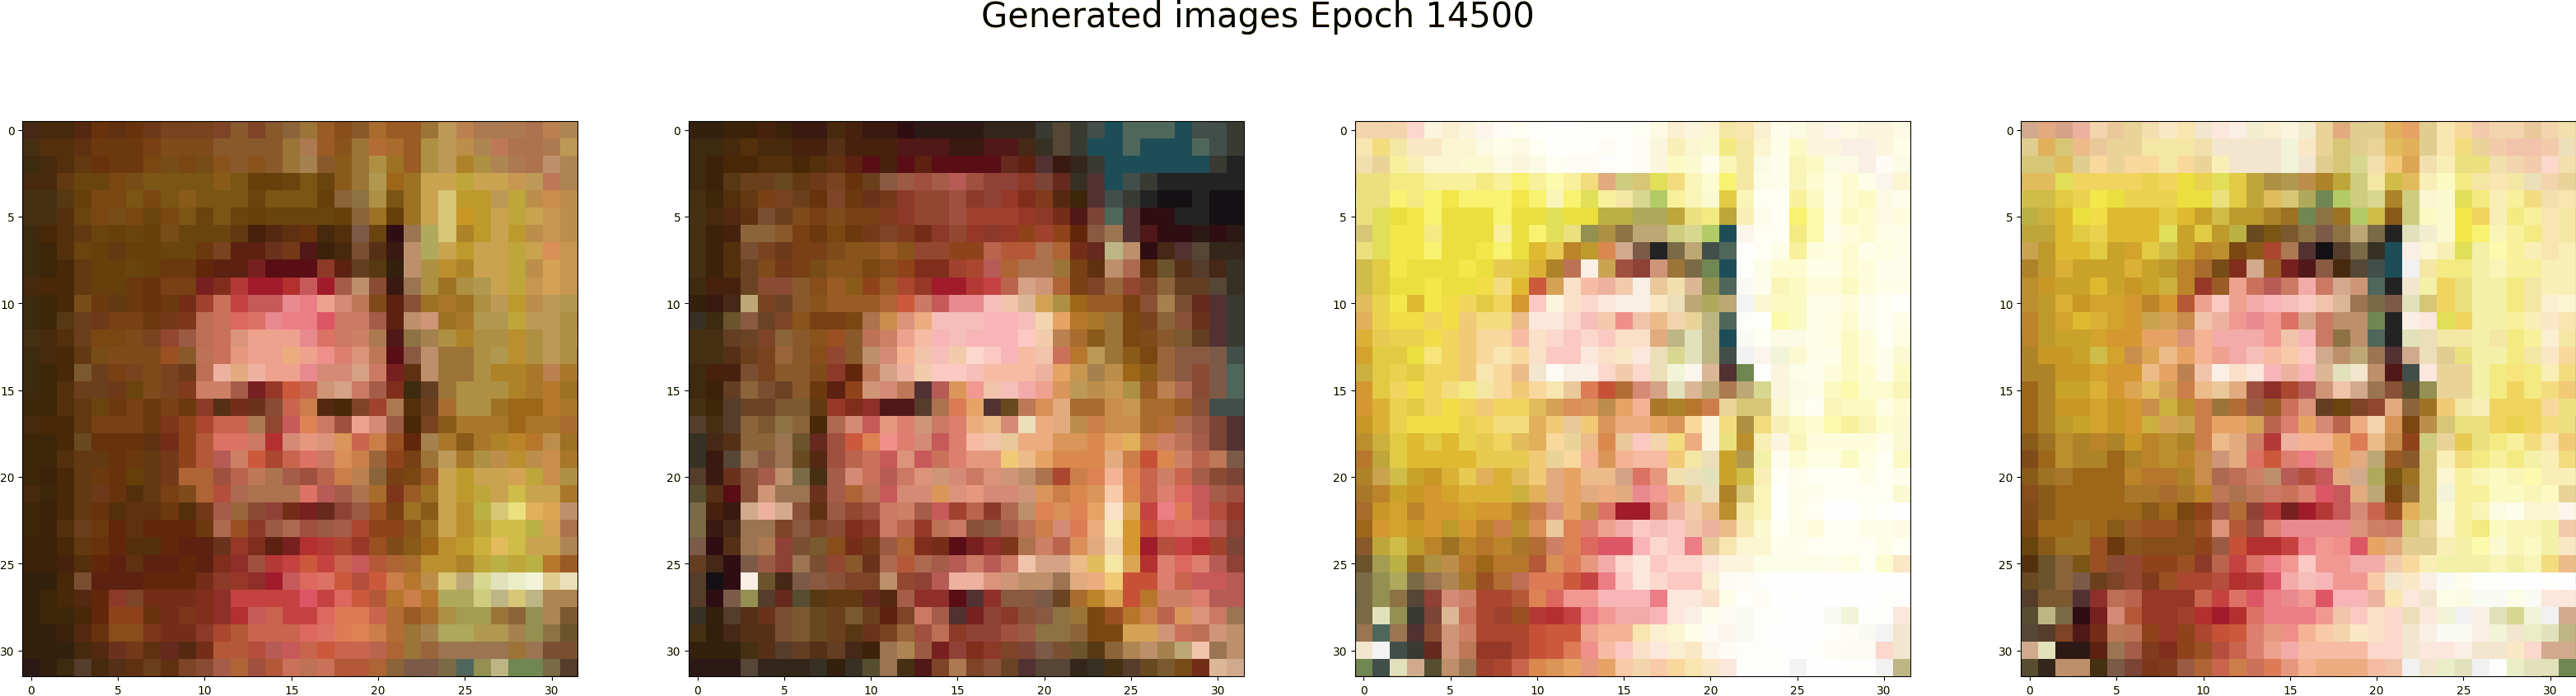

In [7]:
# generate picture 
Image(filename="./result_test32_0003_4/image.png",width=800,height=1000)

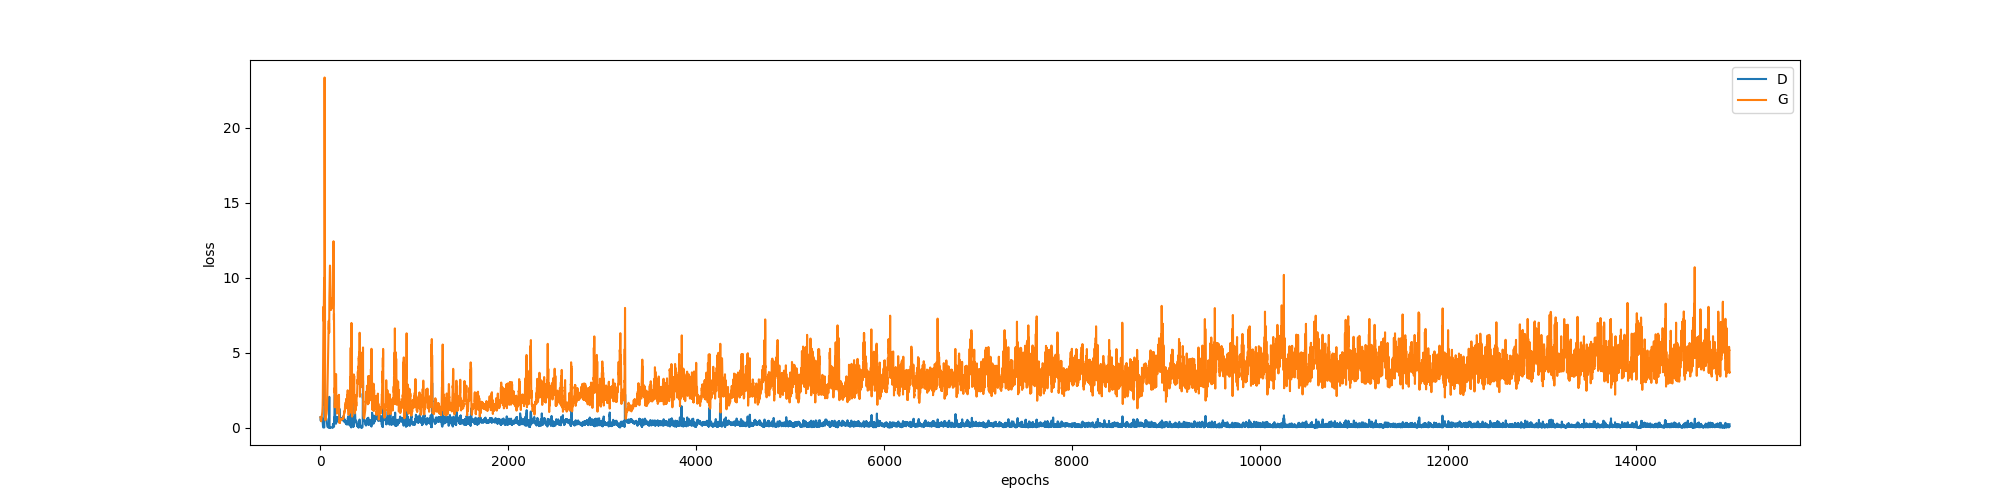

In [8]:
# loss
Image(filename="./result_loss_plot/test32_0003_4.png",width=1000,height=1000)

### lr = 0.0001 

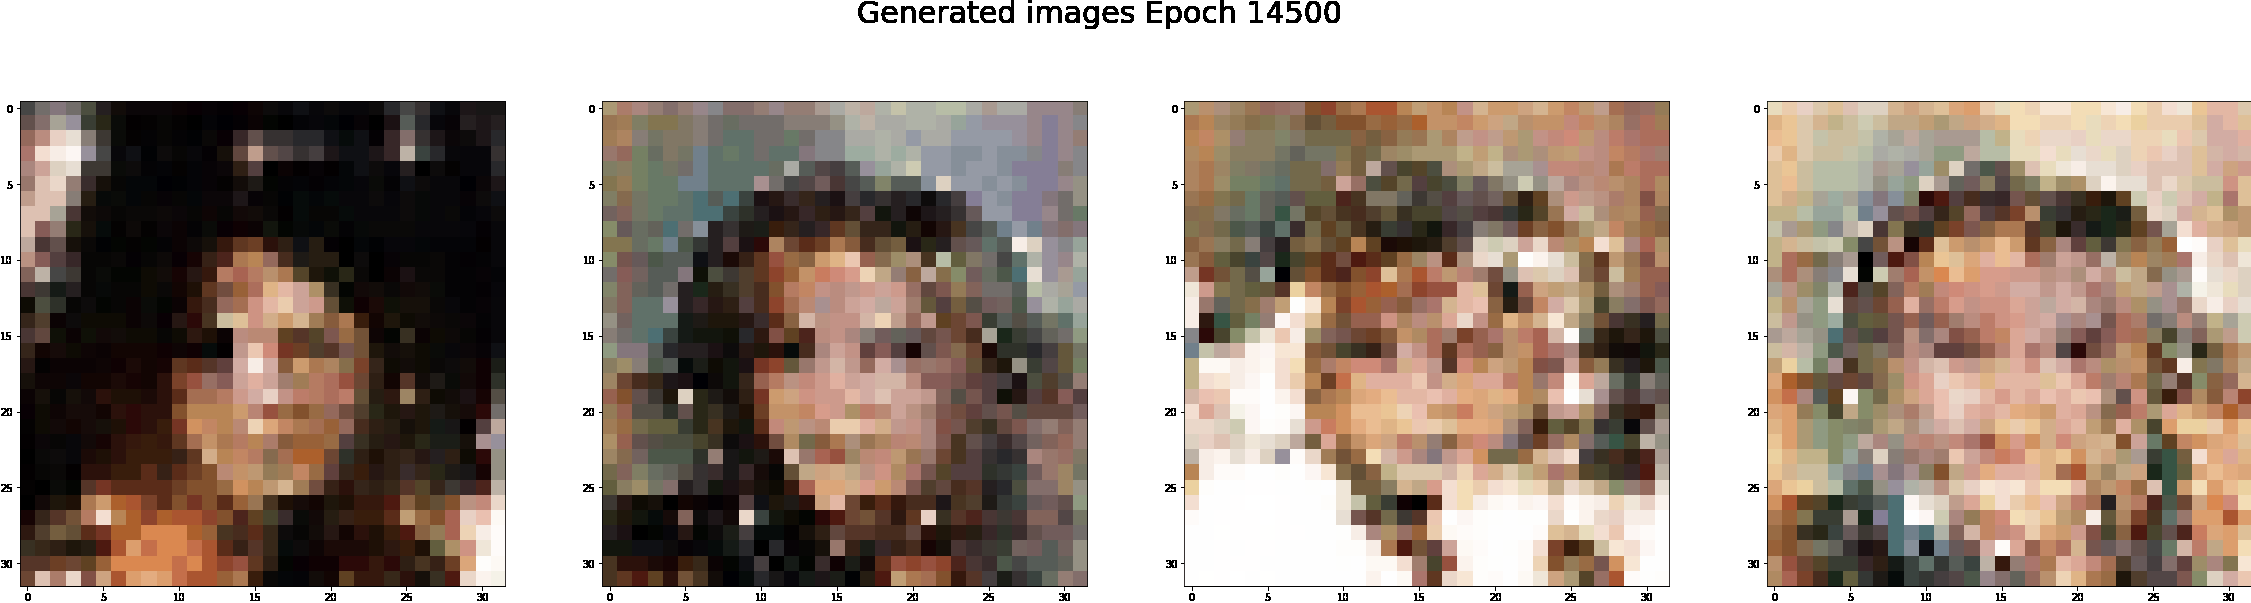

In [9]:
# generate picture 
Image(filename="./result_test32_0001_1/image.png",width=800,height=1000)

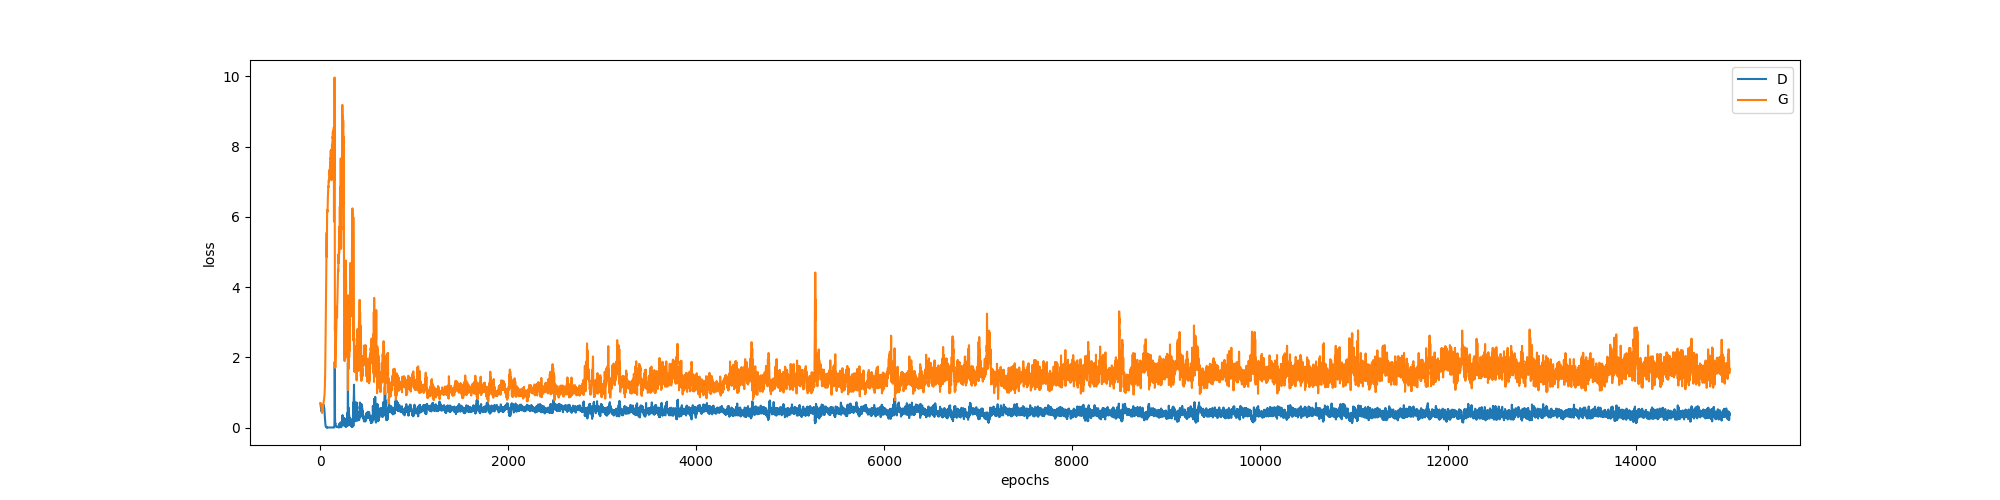

In [10]:
# loss
Image(filename="./result_loss_plot/test32_0001_4.png",width=1000,height=1000)

### lr = 0.00007 

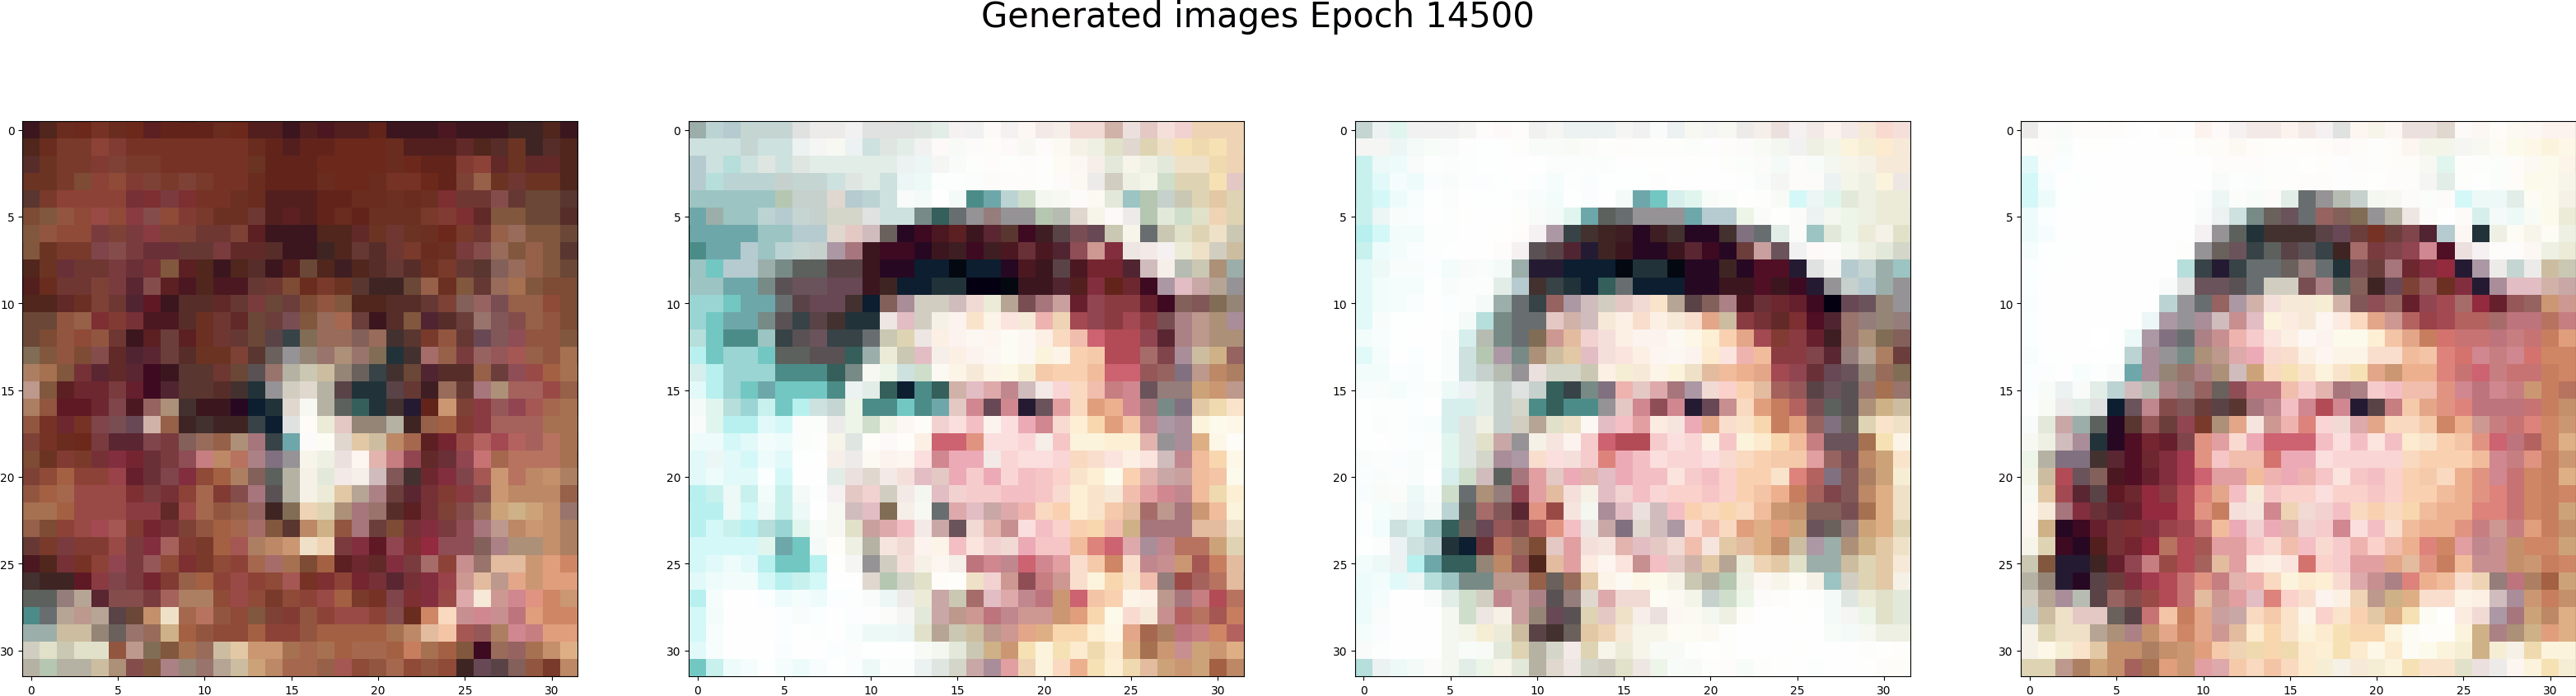

In [11]:
# generate picture 
Image(filename="./result_test32_00007_4/image.png",width=800,height=1000)

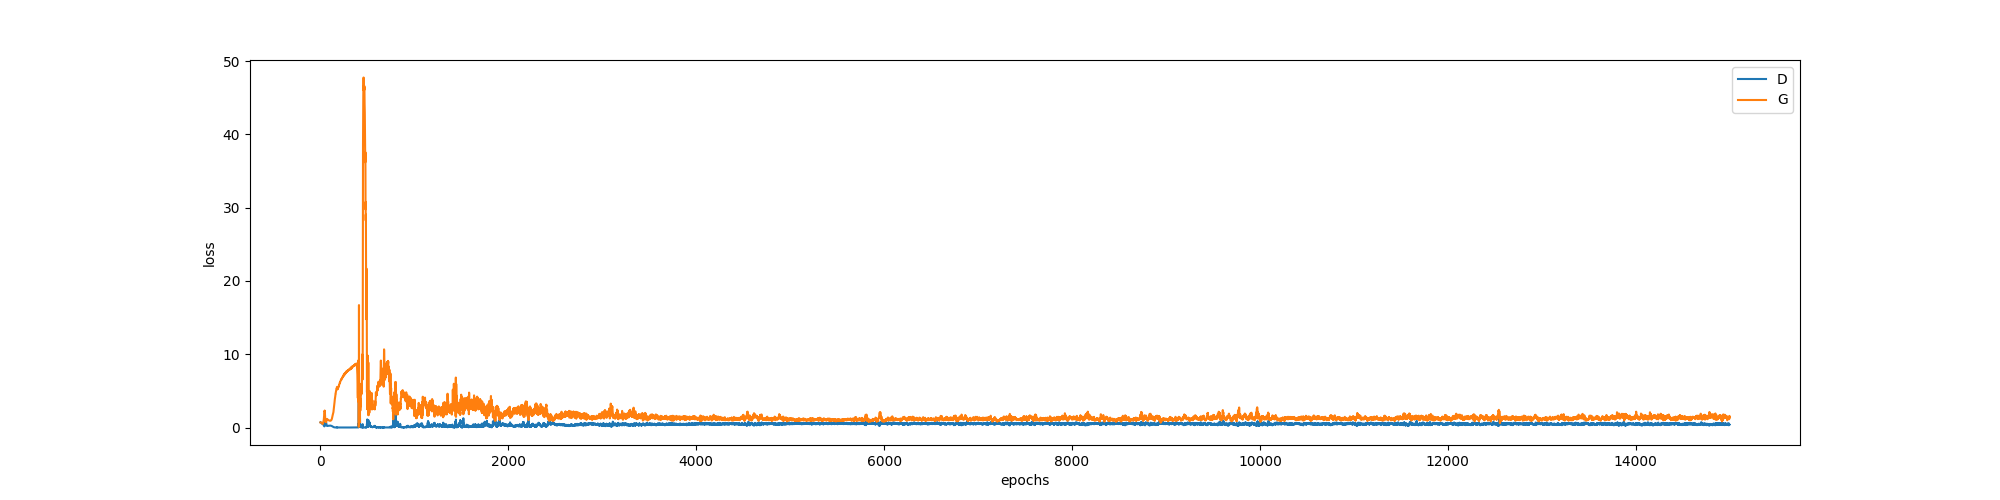

In [12]:
# loss
Image(filename="./result_loss_plot/test32_00007_4.png",width=1000,height=1000)

### dim = 64

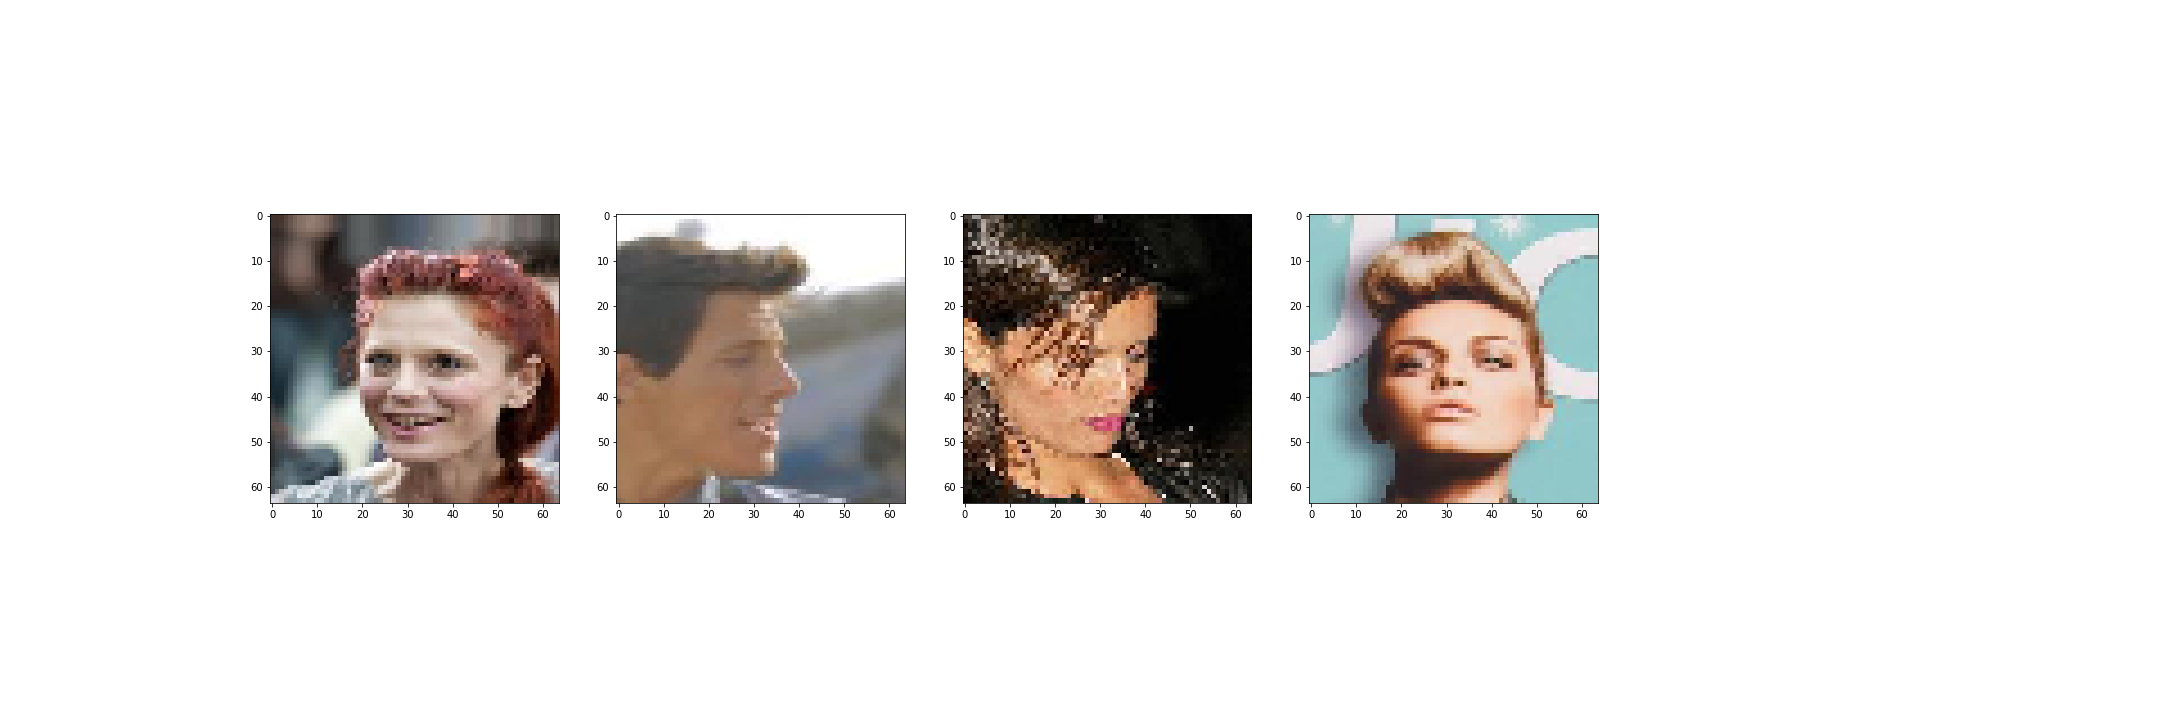

In [13]:
# original photo
Image(filename="./original_photo/original_dim64.png",width=1000,height=1000)

### lr = 0.0003 

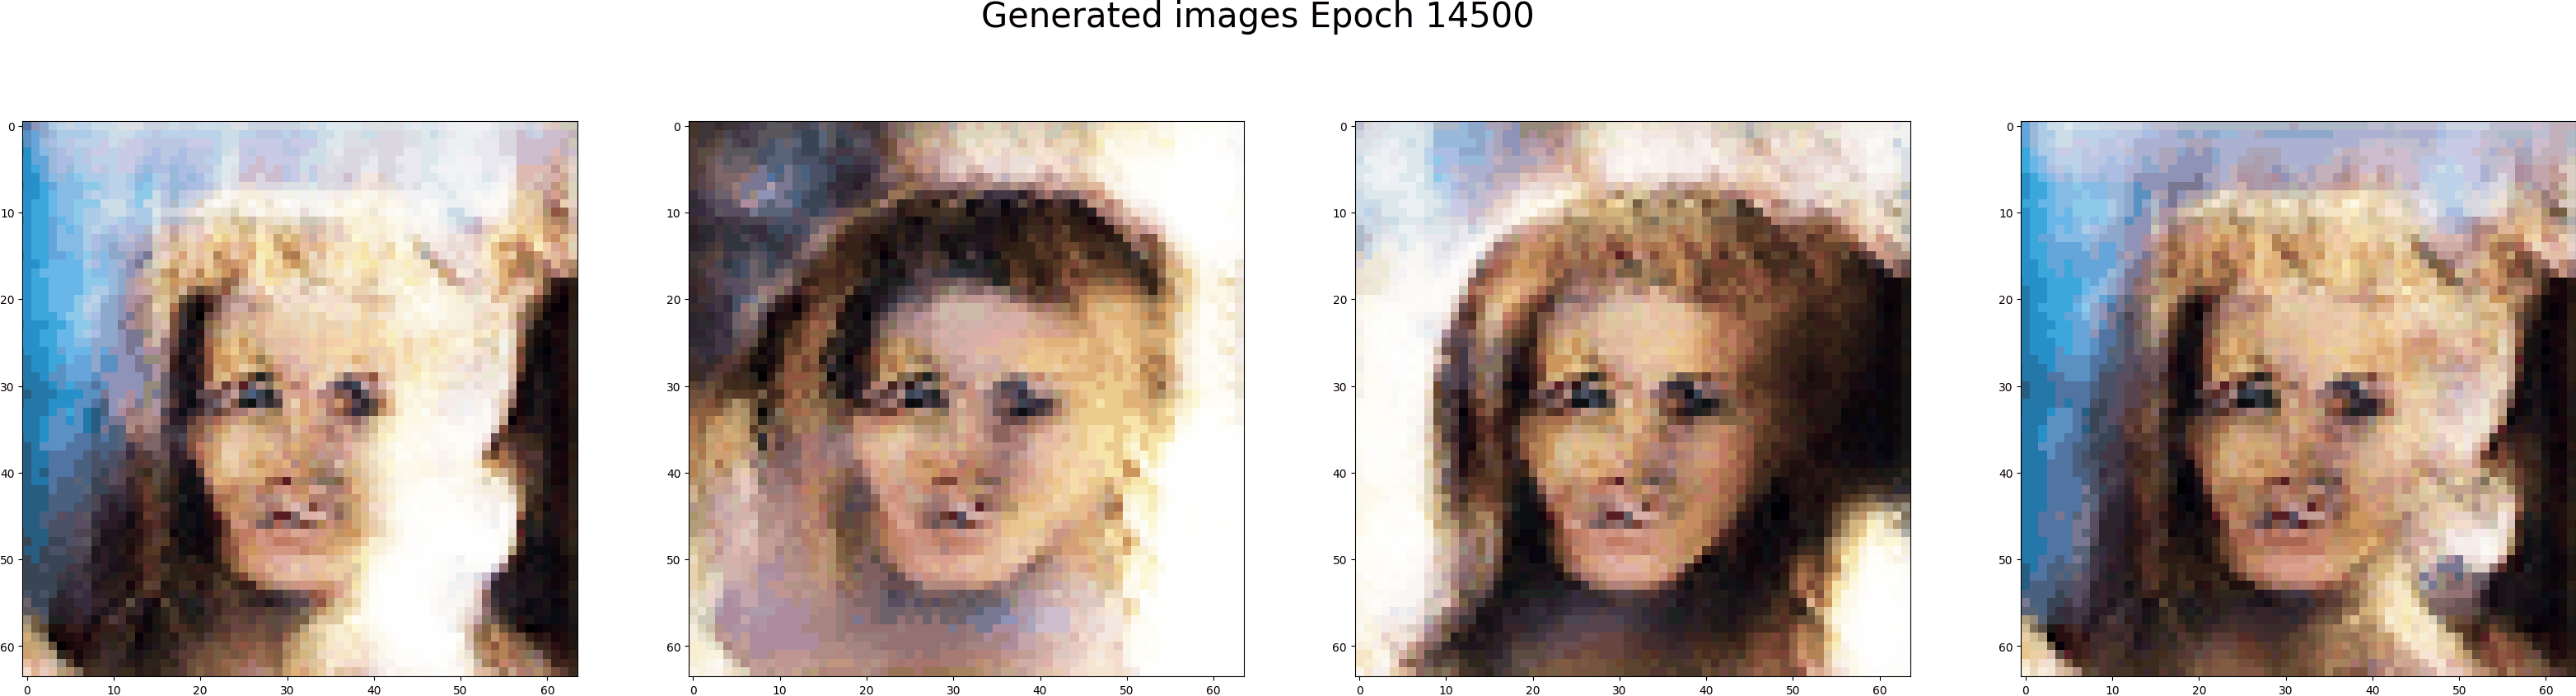

In [14]:
# generate picture 
Image(filename="./result_test64_0003_4/image.png",width=800,height=1000)

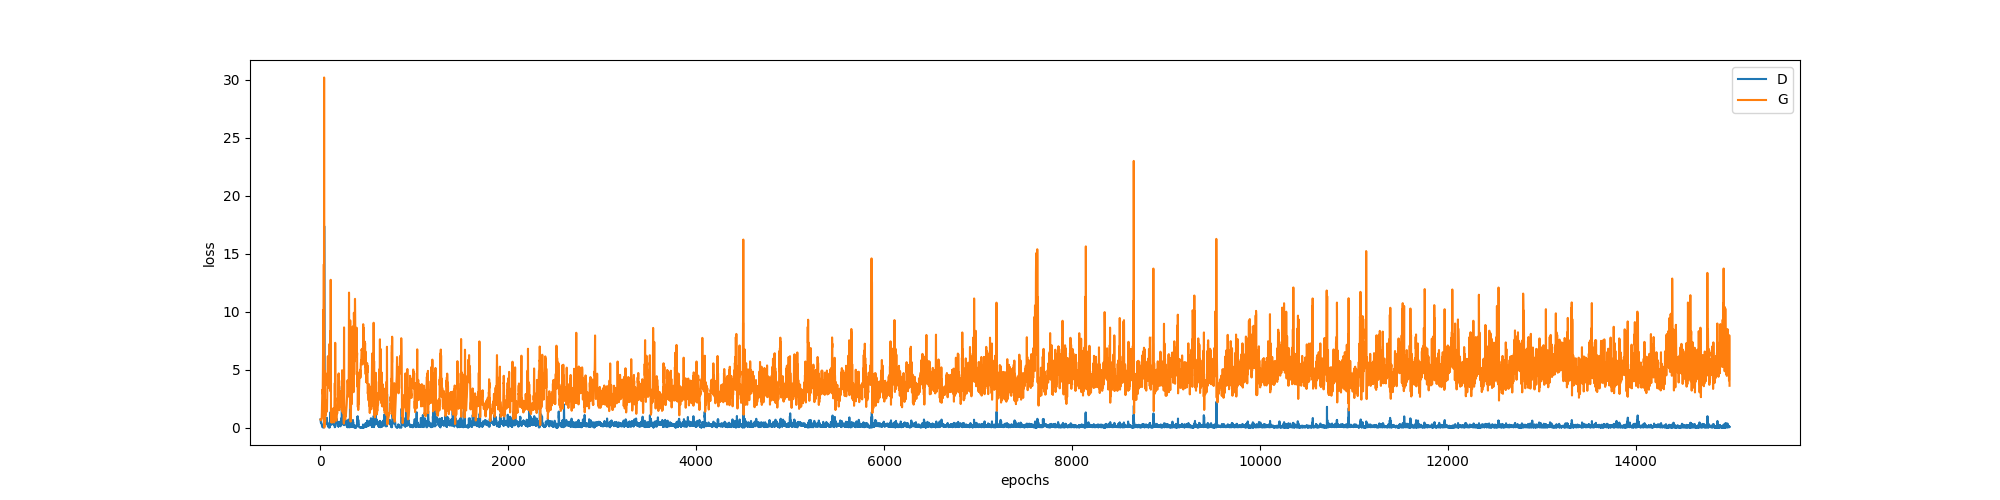

In [15]:
# loss
Image(filename="./result_loss_plot/test64_0003_4.png",width=1000,height=1000)

### lr = 0.0001 

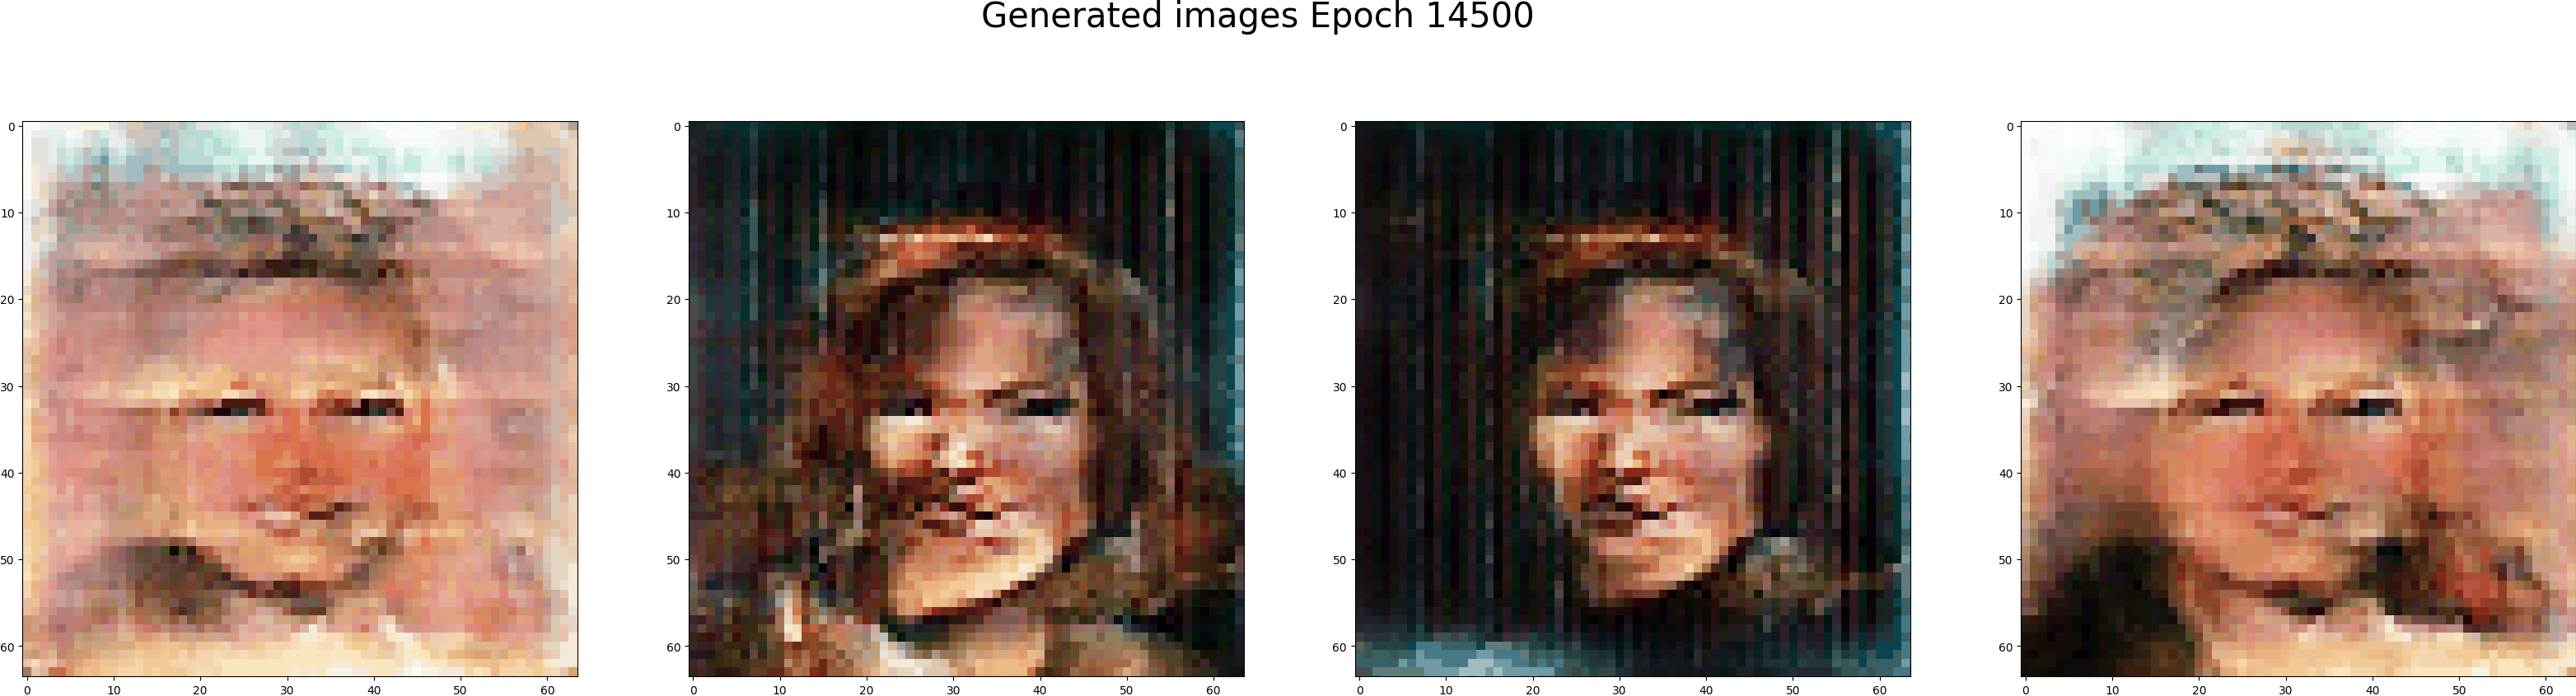

In [16]:
# generate picture 
Image(filename="./result_test64_0001_4/image.png",width=800,height=1000)

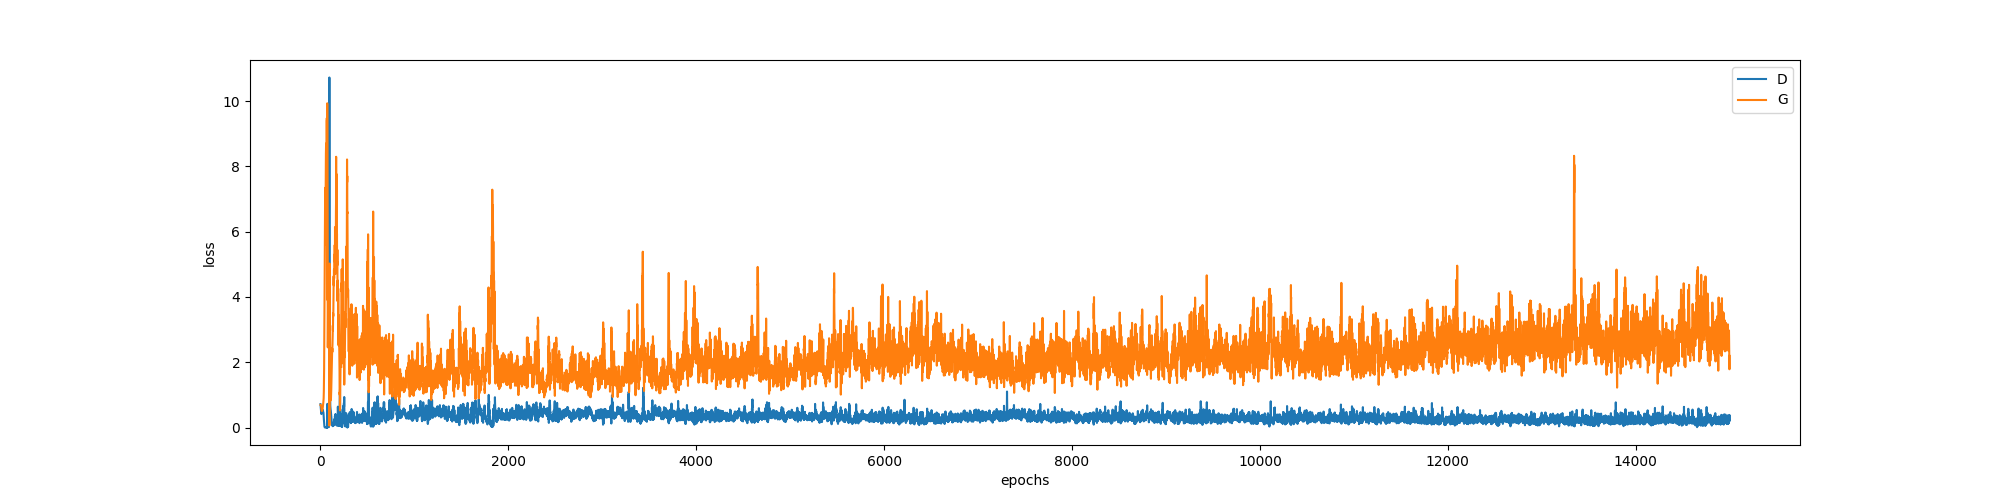

In [17]:
# loss
Image(filename="./result_loss_plot/test64_0001_4.png",width=1000,height=1000)

### lr = 0.00007 

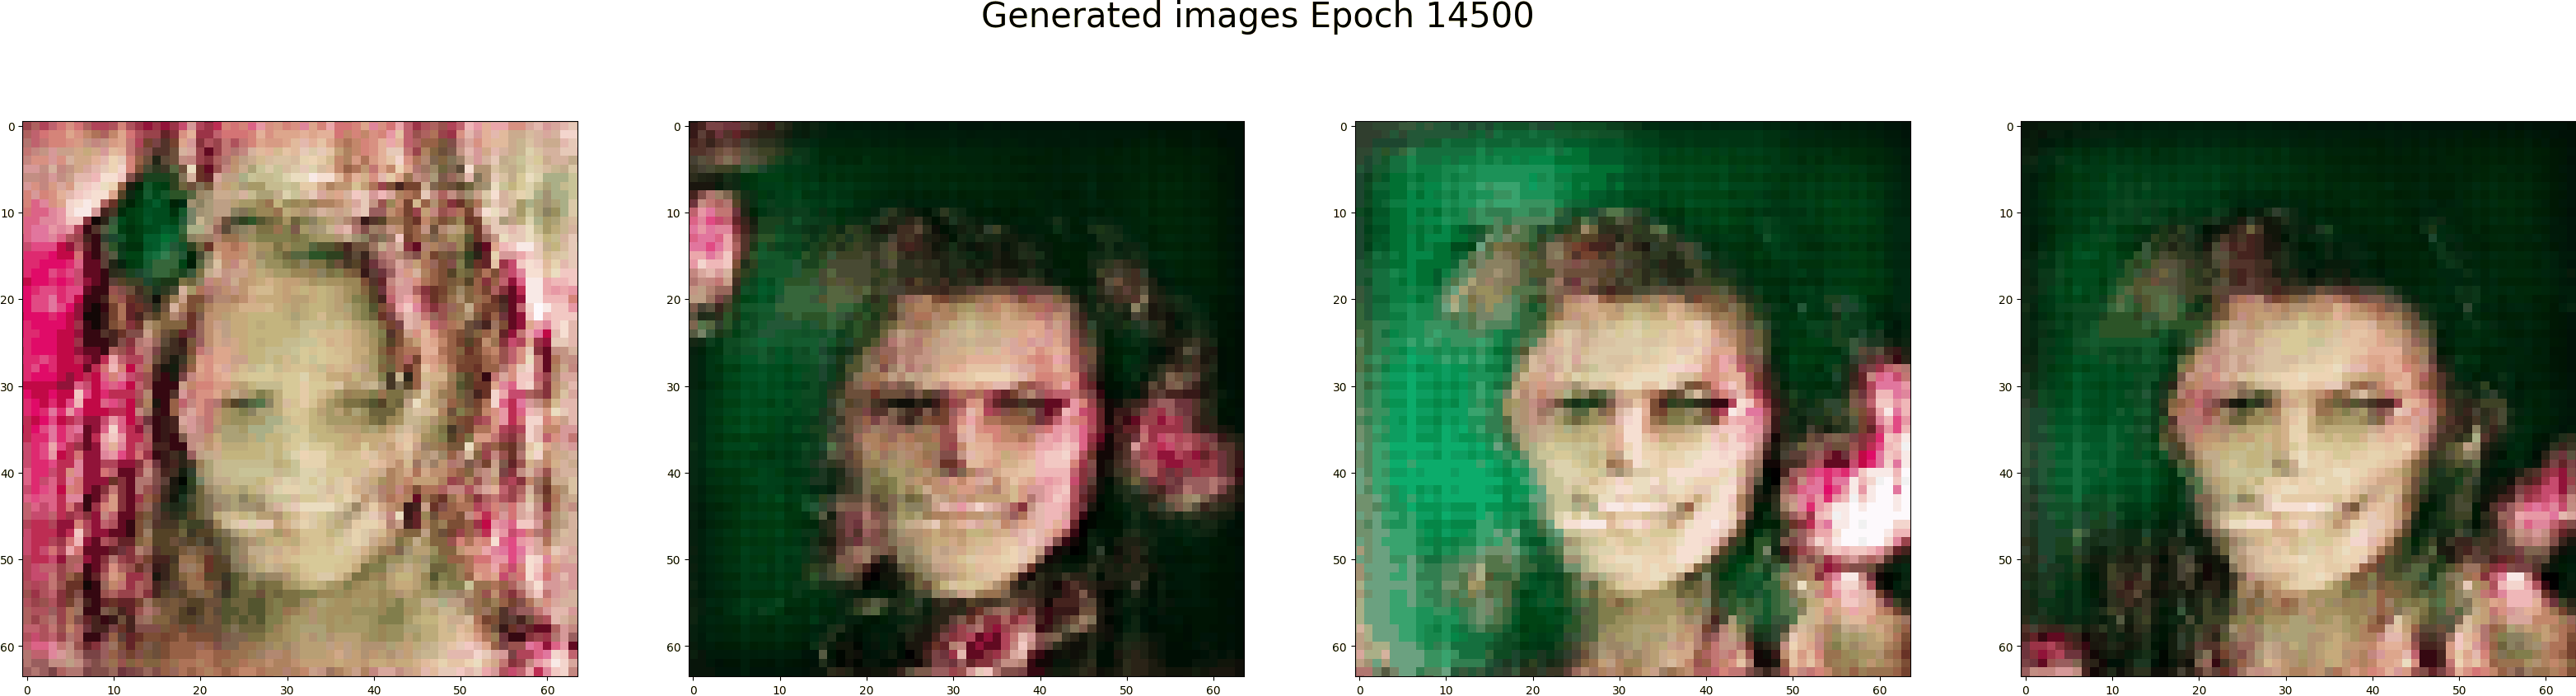

In [18]:
# generate picture 
Image(filename="./result_test64_00007_4/image.png",width=800,height=1000)

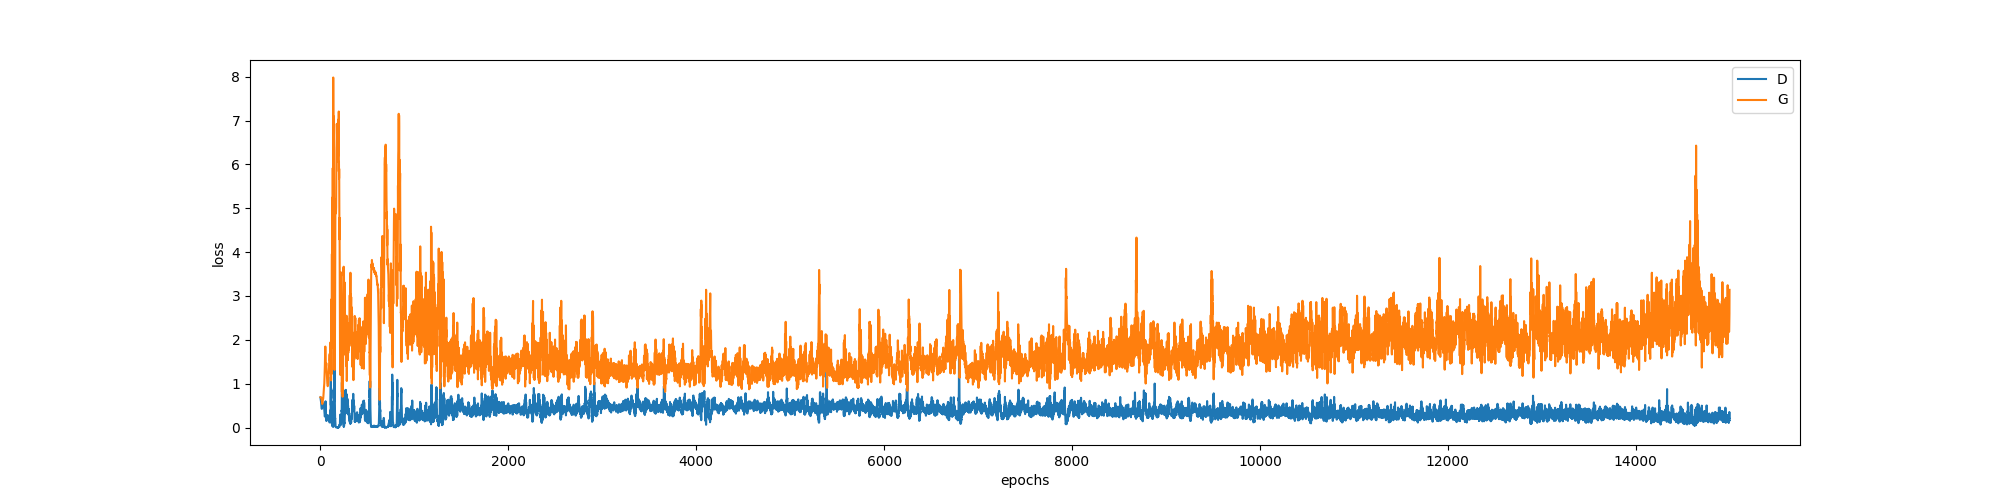

In [19]:
# loss
Image(filename="./result_loss_plot/test64_00007_4.png",width=1000,height=1000)

### dim = 128

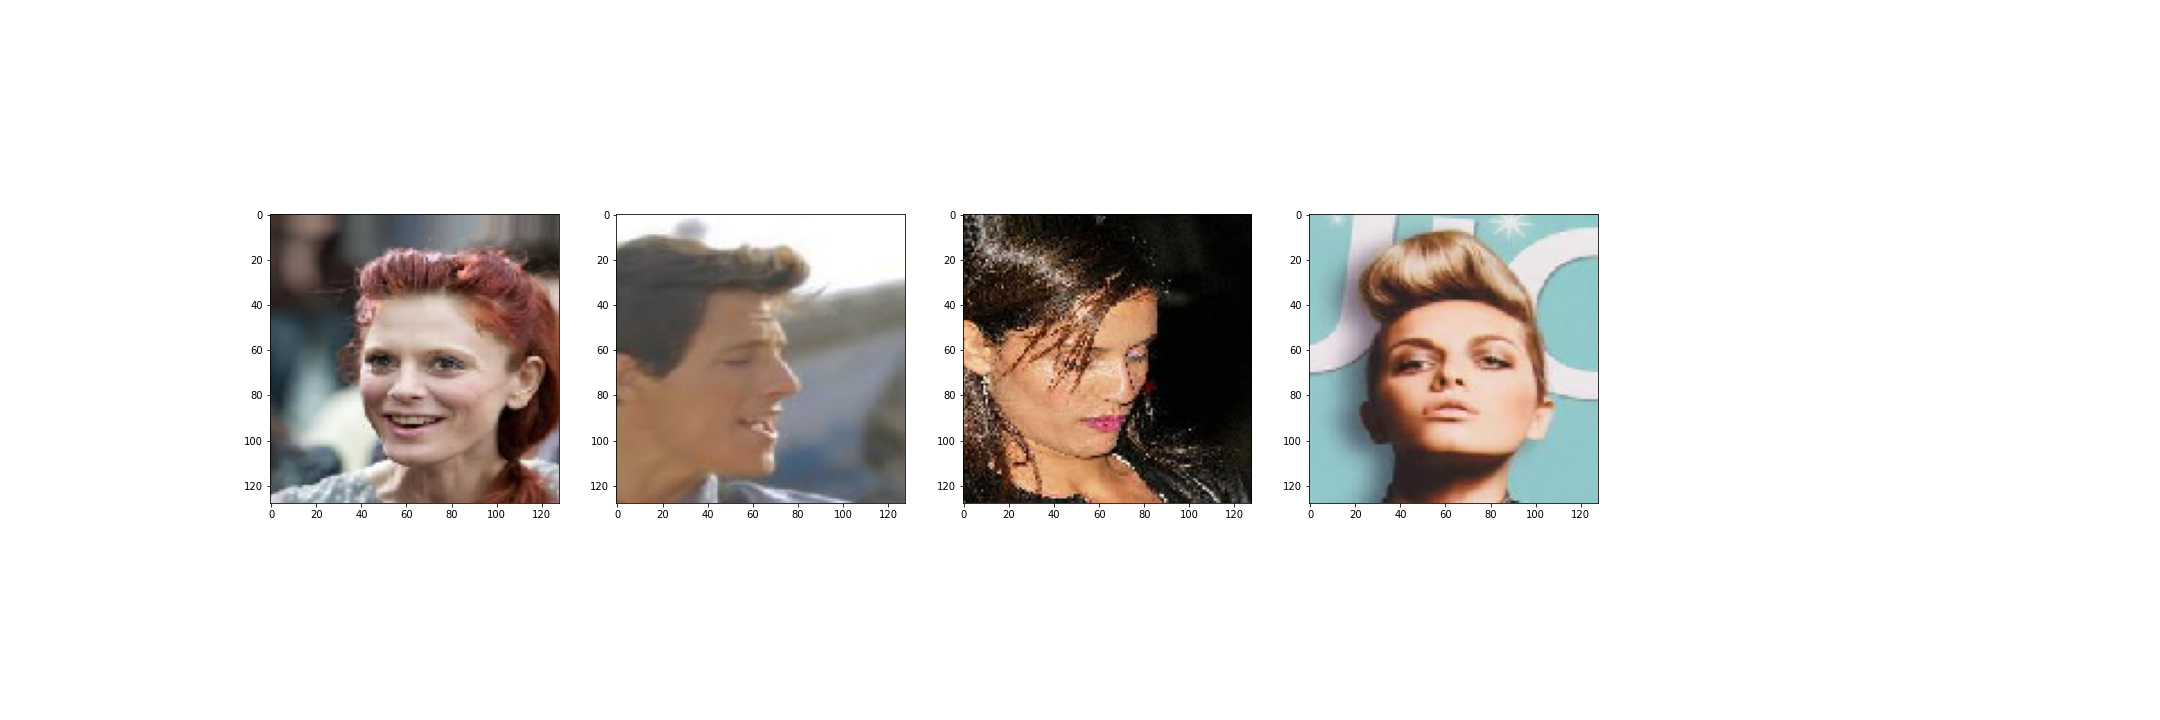

In [20]:
# original photo
Image(filename="./original_photo/original_dim128.png",width=1000,height=1000)

### lr = 0.0003 

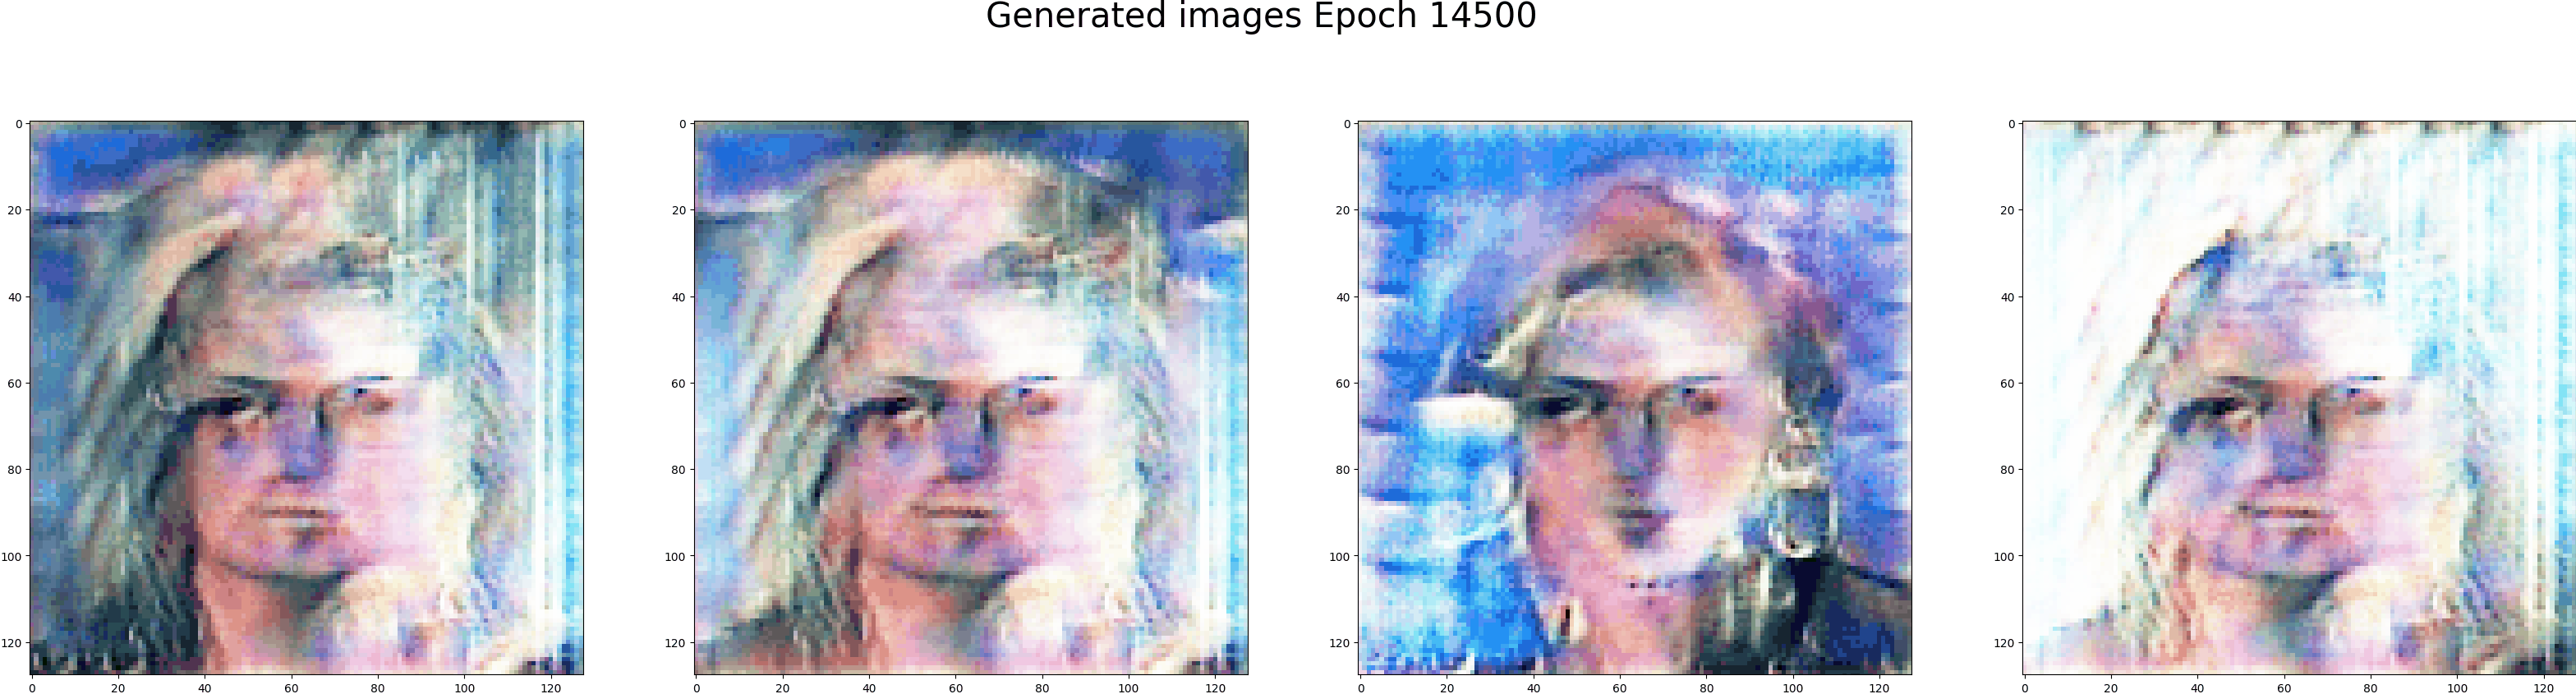

In [21]:
# generate picture 
Image(filename="./result_test128_0003_4/image.png",width=800,height=1000)

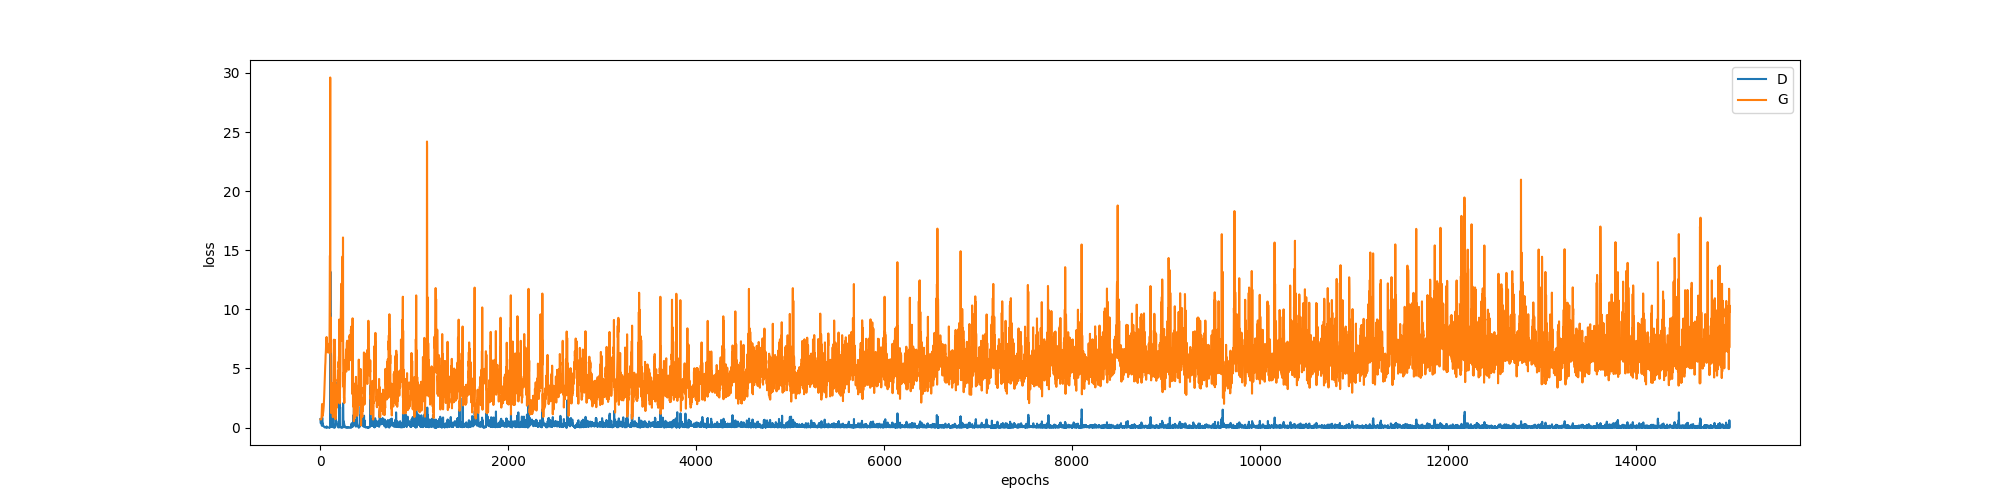

In [22]:
# loss
Image(filename="./result_loss_plot/test128_0003_4.png",width=1000,height=1000)

### lr = 0.0001 

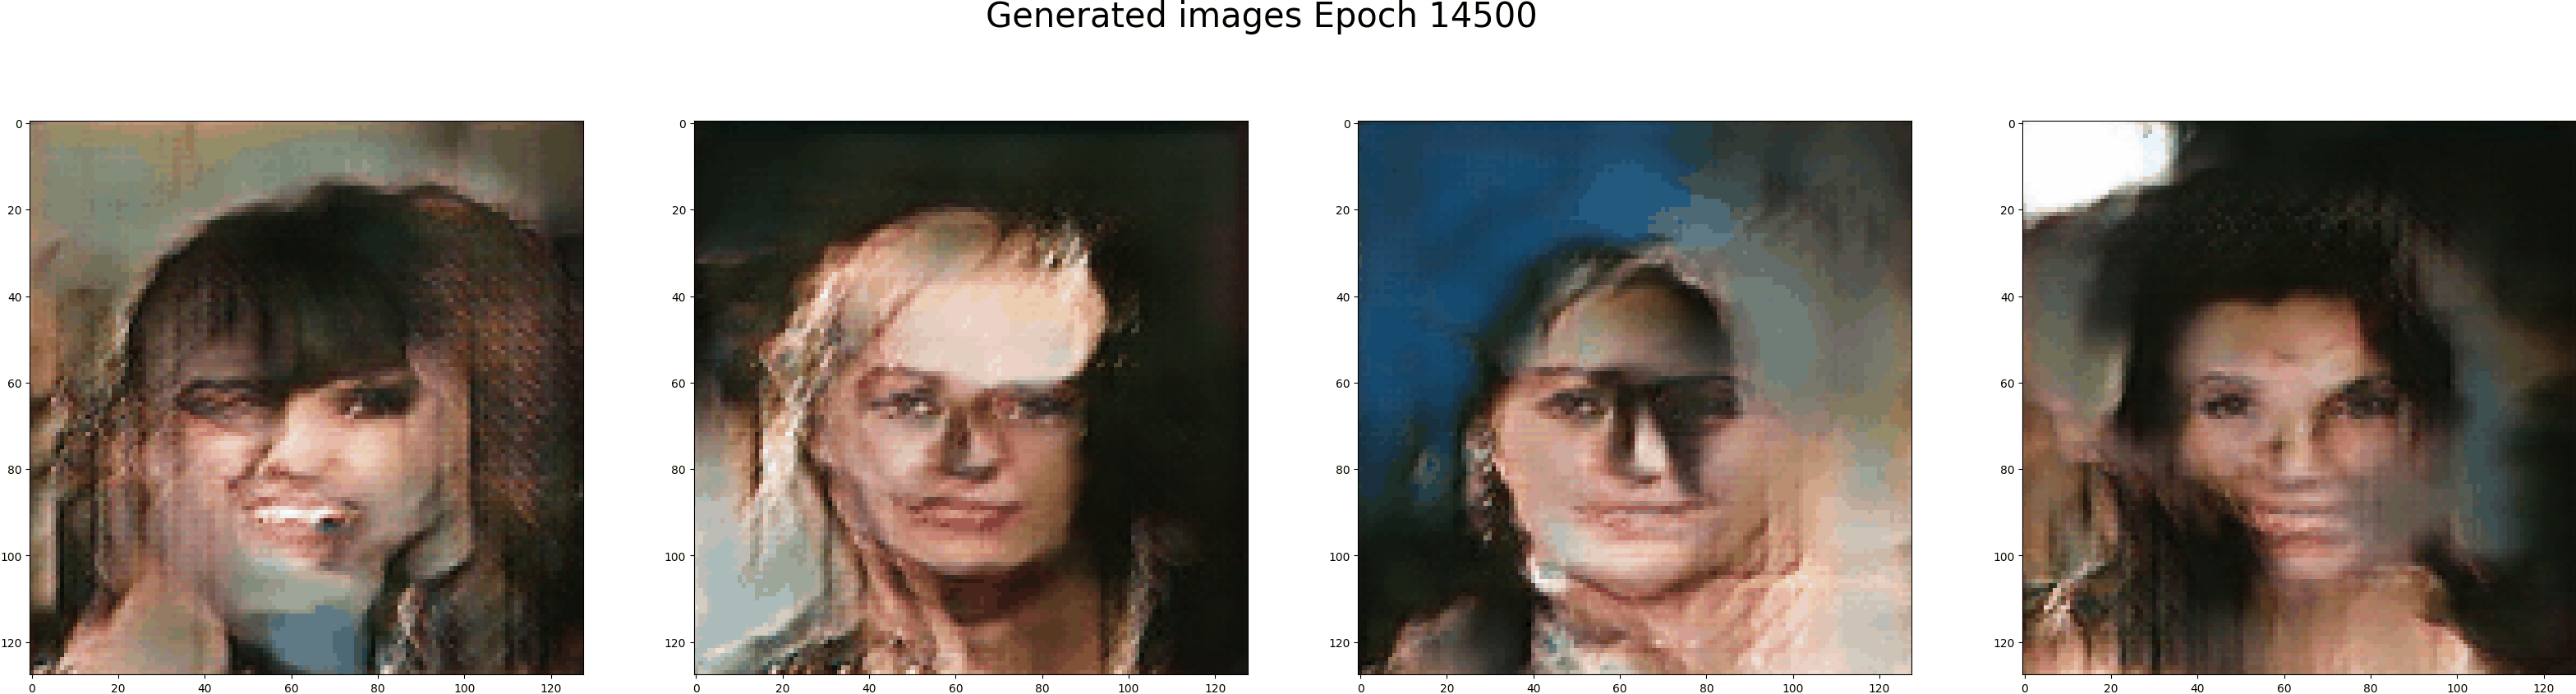

In [23]:
# generate picture 
Image(filename="./result_test128_0001_4/image.png",width=800,height=1000)

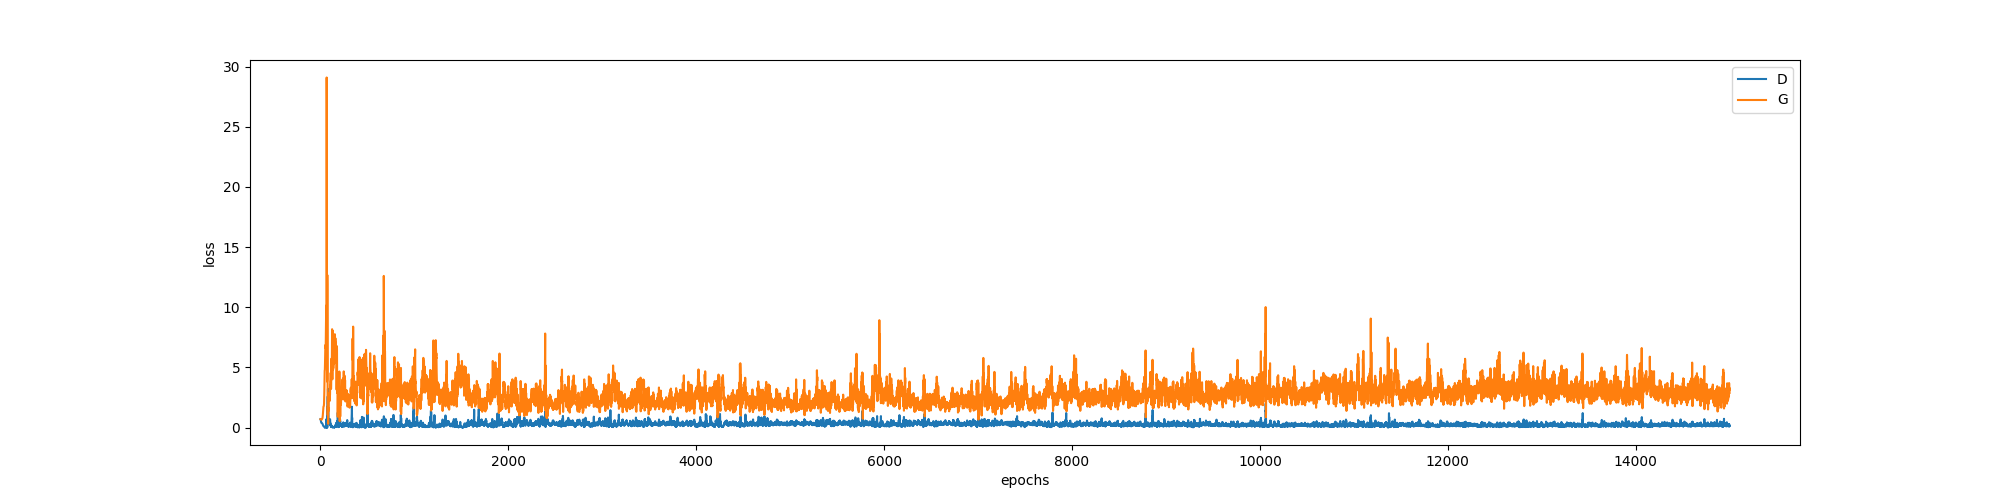

In [24]:
# loss
Image(filename="./result_loss_plot/test128_0001_4.png",width=1000,height=1000)

### lr = 0.00007 

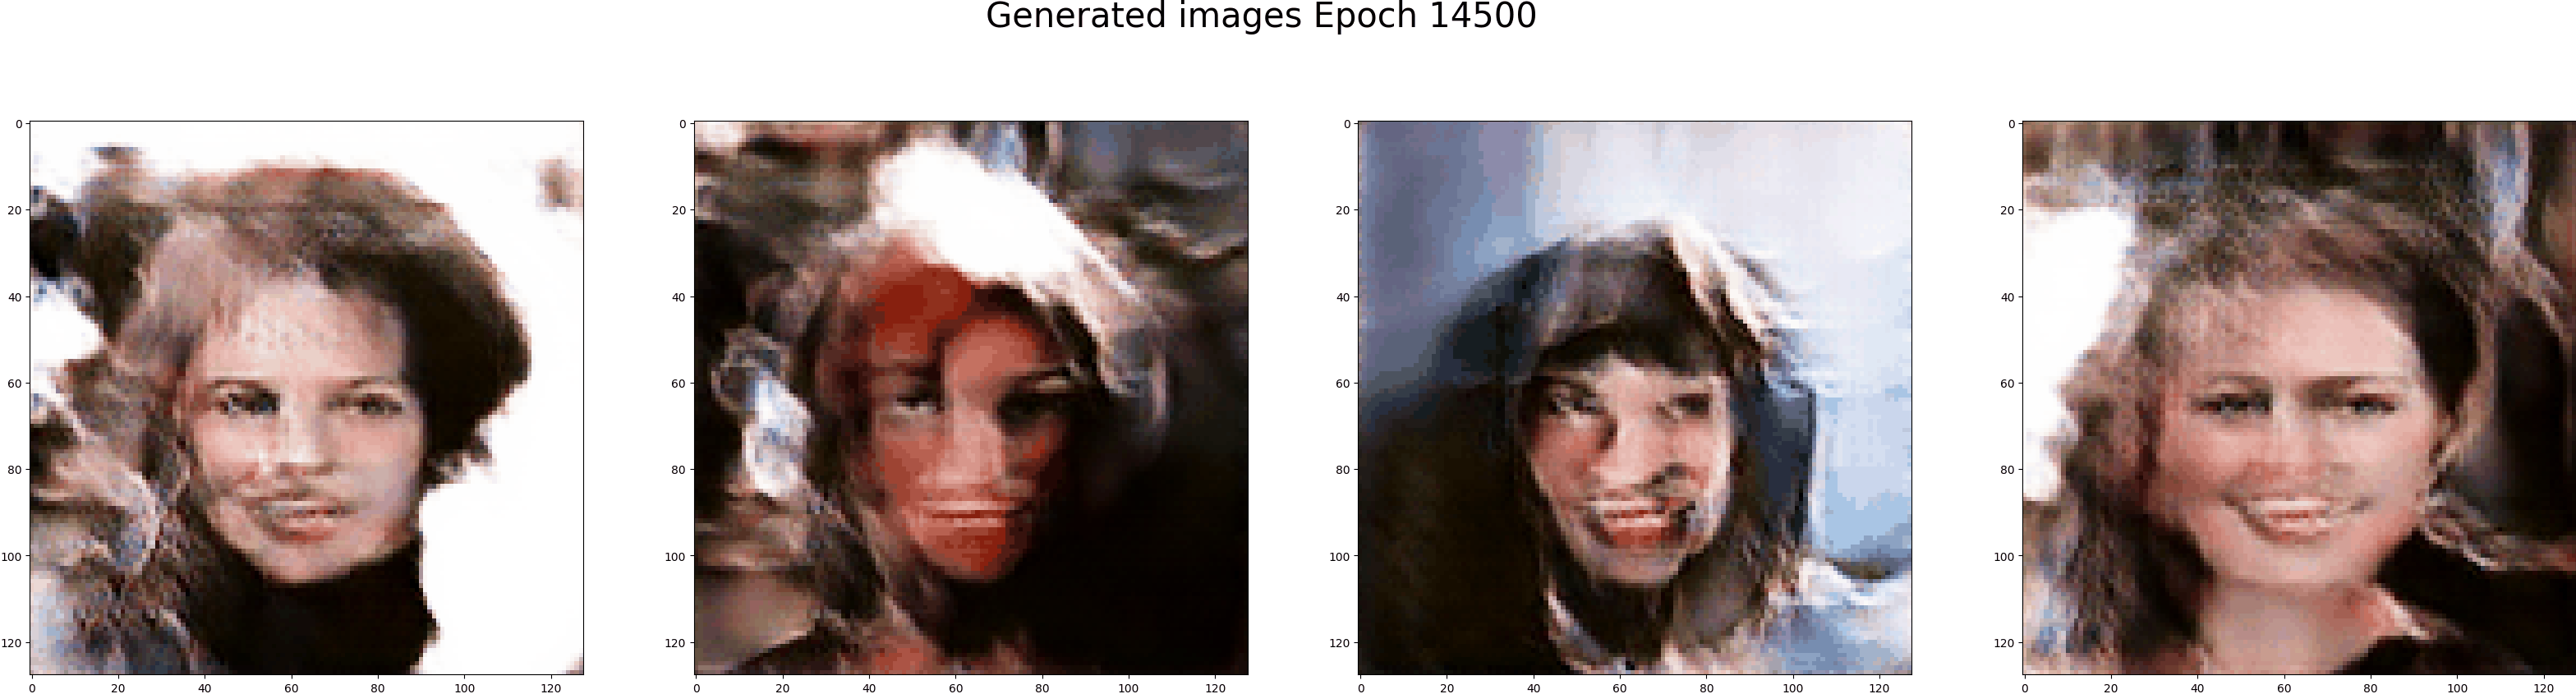

In [25]:
# generate picture 
Image(filename="./result_test128_00007_4/image.png",width=800,height=1000)

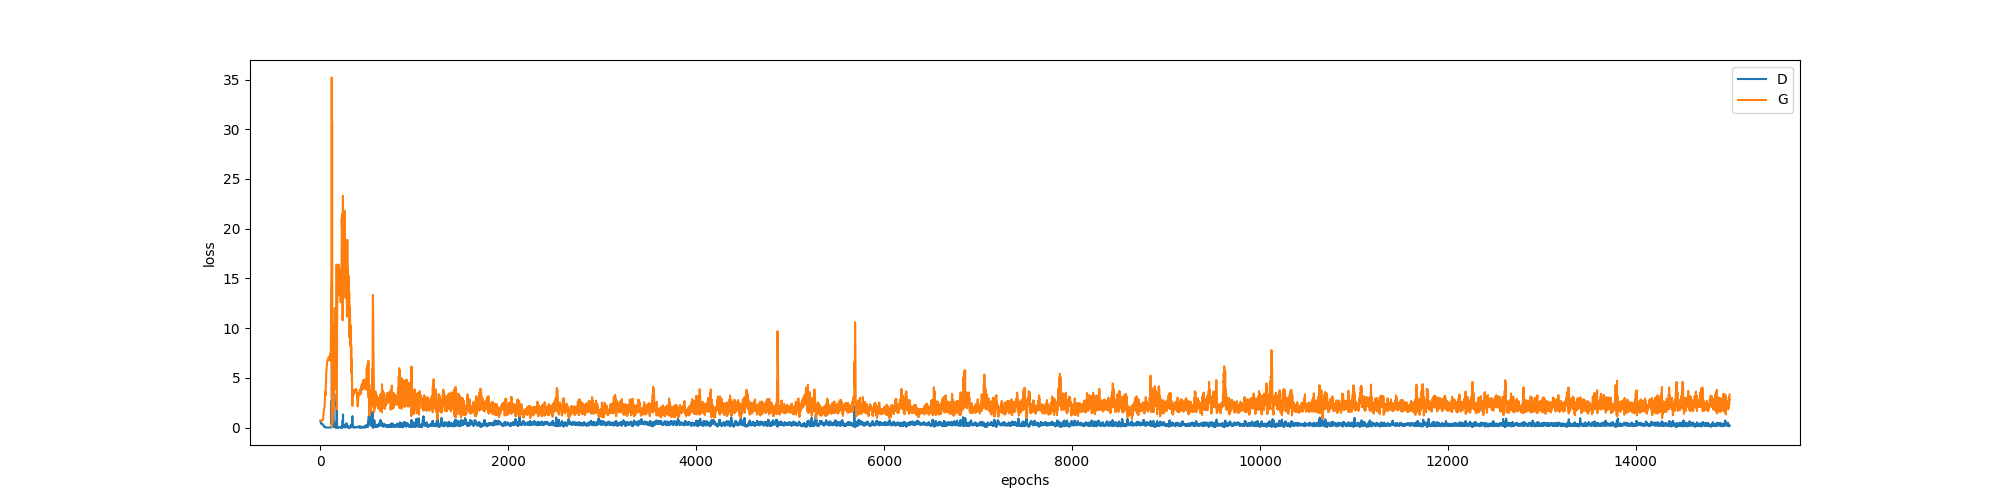

In [26]:
# loss
Image(filename="./result_loss_plot/test128_00007_4.png",width=1000,height=1000)